In [41]:
import igl # Library to load meshes and perform operations on them
import meshplot as mp # Library to visualize meshes and point clouds
import vedo as vd # Library to visualize meshes and point clouds
import polyscope as ps # Library to visualize meshes
import numpy as np # Library to perform operations on matrices
import os # Library to perform operations on files and directories
import matplotlib.pyplot as plt

# Importing the classes and functions from the visualization folder
vd.settings.default_backend = 'k3d'

# Directory path
dir_path = os.getcwd()

First we find all central spheres and build histogram of the radiuses

In [42]:
#Objs/mid_surf_smms_opt.obj - saddle
#Objs/obj_hex/dome1_tri_op.obj - building
#Objs/obj_equilibrium/tri_mesh.obj - hyperboloid
v, f = igl.read_triangle_mesh("C:/Users/aikyna/Desktop/hananLab/hJupyter/models/Hall.obj")
V = len(v) # Number of vertices
F = len(f) # Number of faces

v1, v2, k1, k2 = igl.principal_curvature(v, f)
normals = igl.per_vertex_normals(v, f)
h2 = 0.5 * (k1 + k2)
g2 = k1 * k2

rads = np.zeros(V)
for v_ind in range(V):
    rads[v_ind] = 1.0 / abs(h2[v_ind])

centers = np.zeros((V, 3))
for v_ind in range(V):
    centers[v_ind] = v[v_ind] - normals[v_ind] / h2[v_ind]
#p = mp.plot(v, f, return_plot=True)
#p.add_points(centers, shading={"point_color": "red", "point_size": 0.5})
#p


Next, we find inital point for center of absolute sphere $m$
$$
\text{dist}(m, G_{v_i}) = \frac{1}{2}||n_{v_i}\times (m - v_i)|| = \frac{1}{2}||S_i m - S_i v_i||
$$
where $n_{v_i}, |n_{v_i}|=1$ is normal from $v_i$, $S_i \in \mathbb{R}^{3\times 3}$ such that $S_i m = n_i \times m$. 
$$
\sum_{v_i \in V} \text{dist}(m, G_{v_i})^2 = \sum_{v_i \in V} \frac{1}{4}||S_i m - S_i v_i||^2 \to \text{min} \Rightarrow 
\left\lVert\begin{pmatrix} S_1\\ S_2 \\ . \\ . 
\end{pmatrix} m - \begin{pmatrix} S_1 v_1\\ S_2 v_2\\ . \\ . 
\end{pmatrix}\right\rVert \to \text{min}
$$
Then we can reformulate problem as $S^T S m = S^T b$, where $S^T S \in \mathbb{R}^3$, where $S = (S_1, S_2, \dots), b = (S_1 v_1, S_2 v_2, \dots)$.

In [49]:
def calc_angle_vertices(point, v, V, normals):
    sum = 0
    for v_ind in range(V):
        sum += np.arccos(np.dot(v[v_ind] - point, normals[v_ind]) / np.linalg.norm(v[v_ind] - point)) ** 2
    return (sum)

In [50]:
point1 = np.zeros(3)

matrix_s = np.zeros((3 * V, 3))
vector_b = np.zeros(3*V)
for v_ind in range(V):
    normal = normals[v_ind]
    matrix_s[3 * v_ind, :] = np.array([0, -normal[2], normal[1]])
    matrix_s[3 * v_ind + 1, :] = np.array([normal[2], 0, -normal[0]])
    matrix_s[3 * v_ind + 2, :] = np.array([-normal[1], normal[0], 0])
    vector_b[3 * v_ind:3 * v_ind + 3] = matrix_s[3 * v_ind:3 * v_ind + 3, :] @ v[v_ind]
#print(matrix_s.T@matrix_s)
#print(matrix_s.T@vector_b)

point1 = np.linalg.lstsq(matrix_s.T@matrix_s, matrix_s.T@vector_b, rcond=None)[0]
print(point1, calc_angle_vertices(point1, v, V, normals))

[18.97791031 26.11760639 -4.87671118] 873.1430170704409


In [102]:
vector = np.linalg.lstsq(normals, np.ones(V), rcond=None)[0]
vector = vector/np.linalg.norm(vector)
sum1 = 0
sum2 = 0
for v_ind in range(V):
    sum1 += np.dot(np.cross(normals[v_ind], vector), np.cross(normals[v_ind], vector))
    sum2 += np.dot(np.cross(normals[v_ind], v[v_ind] - point1), np.cross(normals[v_ind], vector))
print(sum2)
print(point1 - (sum2 / sum1) * vector, calc_angle_vertices(point1 - (sum2 / sum1) * vector, v, V, normals))
print(point1 - 20 * vector, calc_angle_vertices(point1 - 50 * vector, v, V, normals))

-3.934452763587615e-11
[18.97791031 26.11760639 -4.87671118] 873.1430170704424
[ 19.18022437  37.46748121 -21.34302257] 1307.243234926093


In [158]:
import math
phi, tetta = np.random.random() * 2 * math.pi, (np.random.random() - 0.5) * math.pi
noise = np.array([np.cos(phi) * np.cos(tetta), np.sin(phi) * np.cos(tetta), np.sin(tetta)])
angle_noise = np.arccos(np.dot(vector, noise)) / math.pi * 180
while(angle_noise < 5 or angle_noise > 90):
    phi, tetta = np.random.random() * 2 * math.pi, (np.random.random() - 0.5) * math.pi
    noise = np.array([np.cos(phi) * np.cos(tetta), np.sin(phi) * np.cos(tetta), np.sin(tetta)])
    angle_noise = np.arccos(np.dot(vector, noise)) / math.pi * 180
print(noise, calc_angle_vertices(point1 - noise * 50, v, V, normals), angle_noise)

[-0.15158736 -0.15966676  0.97546286] 1297.4692940739487 26.458532341765498


In [163]:
print(noise)
print(calc_angle_vertices(point1 - noise * 100000, v, V, normals), calc_angle_vertices(point1 - vector * 100000, v, V, normals))

[-0.15158736 -0.15966676  0.97546286]
2151.8180439334155 2167.9493944542733


In [25]:
v_proj = np.zeros((V,3))
bv = 0
for v_ind in range(V):
    v_proj[v_ind] = v[v_ind] - np.dot(v[v_ind], vector) * vector
    bv += v_proj[v_ind]

bv /= V
point2 = point1 - vector * 22

In [26]:
point = point1

In [28]:
p = mp.plot(v, f, return_plot=True)
#p.add_mesh(v_proj, f, c=v1[:,1])
p.add_lines(v, v + normals, shading={"line_color": "red"});
#p.add_lines(v, v + vector, shading={"line_color": "green"});
p.add_points(np.array([point1, point2]), shading={"point_color": "green", "point_size": 1.0})
p


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(19.867670…

Here, we visualize our mesh and centers of central and absolute sphere.

In [17]:
# Initialize polyscope
ps.init()
ps.remove_all_structures()
 
mesh = ps.register_surface_mesh("Mesh", v, f, smooth_shade=True)
mesh.add_scalar_quantity("Mean curvature", h2)

for _ in range(10):
    i = np.random.randint(0, V-1)
    c = centers[i] 
    sphere = ps.register_point_cloud(f"sphere_c{i}", np.array([c]), enabled=True, color=(0,0,0), transparency=0.5)
    sphere.set_radius(rads[i], relative=False)
#ps_cloud_opt = ps.register_point_cloud("Central spheres", centers, radius=0.01, point_render_mode='sphere')
#center = ps.register_point_cloud("Absolute spheres", np.array([point]), radius=0.01, point_render_mode='sphere')
ps.show()


Second, we find intial radius $R$ for $m$. We find range for $R$ as 
$$
R_{min} = \text{max}_{v_i \in V}|||m - v_i|| - r_i|, \quad R_{max} = \text{min}_{v_i \in V}|||m - v_i|| + r_i|
$$

In [18]:
rad_init_min = abs(np.linalg.norm(point - centers[0]) - rads[0])
rad_init_max = np.linalg.norm(point - centers[0]) + rads[0]

for v_ind in range(V):
    rad_init_min = max(rad_init_min, abs(np.linalg.norm(point - centers[v_ind]) - rads[v_ind]))
    rad_init_max = min(rad_init_max, np.linalg.norm(point - centers[v_ind]) + rads[v_ind])

print("Radius minimum = ", rad_init_min)
print("Radius maximum = ", rad_init_max)

rad_abs = max(rad_init_max, rad_init_min)
    

Radius minimum =  2.0210102482989365
Radius maximum =  3.0374883572115046


In [19]:
# Create mesh vedo
mesh = vd.Mesh([v, f], c="red", alpha=0.5)
s0 = vd.Spheres(centers[10:20,], rads[10:20,], c = "yellow", alpha = 0.1)
s1 = vd.Spheres([point], [rad_abs], c="green", alpha=0.5)
vd.show(mesh, s0, s1)


Plot(antialias=True, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], backgro…

In [20]:
# Initialize polyscope
ps.init()
ps.remove_all_structures()
 
mesh = ps.register_surface_mesh("Mesh", v, f, smooth_shade=True)
mesh.add_scalar_quantity("Mean curvature", h2)

for _ in range(10):
    i = np.random.randint(0, V-1)
    c = centers[i] 
    sphere = ps.register_point_cloud(f"sphere_c{i}", np.array([c]), enabled=True, color=(0,0,0), transparency=0.3)
    sphere.set_radius(rads[i], relative=False)

sphere = ps.register_point_cloud(f"abs_sphere", np.array([point]), enabled=True, color=(0,255,0), transparency=0.5)
sphere.set_radius(rad_abs, relative=False)

#ps_cloud_opt = ps.register_point_cloud("Central spheres", centers, radius=0.01, point_render_mode='sphere')
#center = ps.register_point_cloud("Absolute spheres", np.array([point]), radius=0.01, point_render_mode='sphere')
ps.show()


Here we calculate the number of spheres that do not intersect with absolute sphere
$$
|R_{abs} - r_i| < ||m_{abs} - c_i|| < R_{abs} + r_i
$$

In [21]:
count = 0
energy = 0
for v_ind in range(V):
    dist = np.linalg.norm(point - centers[v_ind])
    if (dist >= rad_abs + rads[v_ind] or dist <= abs(rad_abs - rads[v_ind])):
        count+= 1
    energy += (dist **2 - rad_abs ** 2 - rads[v_ind] **2) ** 2

print("Number of spheres that do not intersect with abs sphere =", count)
print(energy)

Number of spheres that do not intersect with abs sphere = 1
37186.77820961998


Consider the following energy for $m$ and $R$
$$
E_{\text{abs sphere}} = \sum_{i} \Big\lVert||c_i - m||^2 - R^2 - r^2_i\Big\rVert^2 = 
$$
$$
= \sum_{i} \Big\lVert (c_i - m)\cdot (c_i - m) - A - r^2_i\Big\rVert^2
$$
$$
J_{i, j} = \partial_m((c_i - m)\cdot (c_i - m)) = -2(c_i - m), \quad j \in \{1,2,3\}, \quad J_{i, 4} = \partial_A(A) = -1,
$$
$$
r_{i} = (c_i - m) \cdot (c_i - m)
$$
where $J \in \mathbb{R}^{V\times 4}, r \in \mathbb{R}^V$.

In [22]:
J = np.zeros((V, 4))
r = np.zeros(V)

In [23]:
def compute_J(v, f, normals, X, centers, rads, p_length):
    # Hint: consider the first 4 rows of the J matrix 
    # as the ones related to the first sum and the last rows related to the second sum
    for v_ind in range(V):
        center_var = X[0:3]
        rad_var = X[3]
        p_length[v_ind] = np.linalg.norm(v[v_ind] - center_var)
        
        # Edge constraint (c-v)*n_f - 1 + (\mu_1)^2 = 0
        J[v_ind, 0:3] = -2 * (centers[v_ind] - center_var)
        J[v_ind, 3] = -1

        r[v_ind] = np.dot(centers[v_ind] - center_var, centers[v_ind] - center_var) - rad_var - rads[v_ind] * rads[v_ind]
        
        # if np.sign(np.dot(v[v_ind] - center_var, normals[v_ind])) == -1:
        #     print("Error negative sign index", v_ind)
        #     print(f"Point: {v[v_ind]} \t center: {center_var}\n  p-c :{v[v_ind] - center_var}\n normal: {normals[v_ind]}") 

In [24]:
X_0 = np.concatenate((point, [rad_abs * rad_abs]))
p_length = np.zeros(V)

In [25]:
from scipy.sparse import csr_matrix, csc_matrix, coo_matrix, linalg

# Compute pseudo Hessian
X = X_0

# Get center
c = X[:3]

for v_ind in range(V):
    p_length[v_ind] = np.linalg.norm(v[v_ind] - point)

for i in range(20):
    compute_J(v, f, normals, X, centers, rads, p_length)    

    H = J.T@J

    H[np.diag_indices_from(H)] += np.diag(H).max()*1e-6

    # Sparse matrix H
    H = csc_matrix(H)

    # Solve for dx
    dx = linalg.spsolve(H, -J.T@r)
    # Update vertices
    X = X + 0.9*dx
    
    # energy
    energy = r.T@r
    print(f"energy: {energy}\t dx: {np.linalg.norm(dx)}")
print(X[0:3], np.sqrt(X[3]))


energy: 37186.778209620024	 dx: 3.9574996464130376
energy: 1018.9011175007827	 dx: 0.3902308930183943
energy: 666.2963745349534	 dx: 0.03898451779279616
energy: 662.7787724198896	 dx: 0.003899814832824626
energy: 662.7435978351657	 dx: 0.0003901708173847794
energy: 662.7432460194985	 dx: 3.9036562518342504e-05
energy: 662.7432425005576	 dx: 3.905610864453848e-06
energy: 662.7432424653603	 dx: 3.9075671224901453e-07
energy: 662.7432424650082	 dx: 3.90952455380328e-08
energy: 662.7432424650046	 dx: 3.911482321371614e-09
energy: 662.7432424650045	 dx: 3.913445492903238e-10
energy: 662.7432424650046	 dx: 3.9153867553262207e-11
energy: 662.7432424650046	 dx: 3.918114830488313e-12
energy: 662.7432424650045	 dx: 3.923756433551991e-13
energy: 662.7432424650046	 dx: 3.896841184214873e-14
energy: 662.7432424650045	 dx: 4.246451218970649e-15
energy: 662.7432424650045	 dx: 5.815272688802758e-16
energy: 662.7432424650046	 dx: 1.6017929053949194e-16
energy: 662.7432424650046	 dx: 3.602031761719806e-

In [26]:
p = mp.plot(v, f, return_plot=True)
p.add_points(np.array([X[0:3]]), shading={"point_color": "red", "point_size": 1.0})
p


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-3.993511…

In [27]:
center_abs = X[0:3]
rad_abs = np.sqrt(X[3])

In [28]:
count = 0
energy = 0
for i in range(V):
    dist = np.linalg.norm(center_abs - centers[i])
    if (dist >= (rad_abs + rads[i]) or dist <= abs(rad_abs - rads[i])):
        count+= 1
    energy += (dist **2 - rad_abs ** 2 - rads[i] **2) ** 2

print("Number of spheres that do not intersect with abs sphere =", count, "out of", V)
print(energy)

Number of spheres that do not intersect with abs sphere = 0 out of 2639
662.7432424650029


Sum of the square of angles per vertex = 23.148428695984293


(array([ 42., 114., 237., 214., 217., 240., 290., 359., 603., 323.]),
 array([1.39974460e-02, 3.68588951e+00, 7.35778158e+00, 1.10296737e+01,
        1.47015657e+01, 1.83734578e+01, 2.20453499e+01, 2.57172419e+01,
        2.93891340e+01, 3.30610261e+01, 3.67329181e+01]),
 <BarContainer object of 10 artists>)

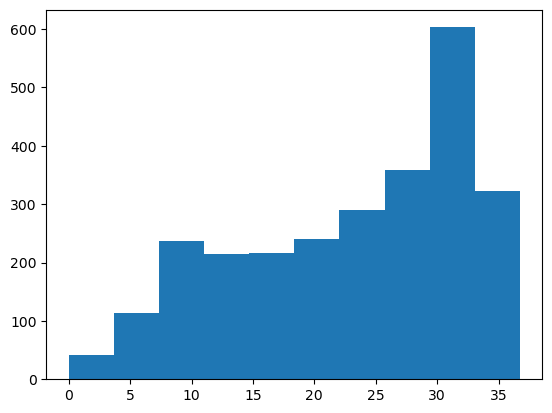

In [29]:
import math

sum_angles = 0
angles = np.zeros(V)
for v_ind in range(V):
    angles[v_ind] = np.arccos(abs(np.dot(center_abs - v[v_ind], normals[v_ind]) / np.linalg.norm(center_abs - v[v_ind]))) / math.pi * 180
    sum_angles += angles[v_ind]

print("Sum of the square of angles per vertex =", sum_angles / V)
counts, bins = np.histogram(angles)
plt.hist(bins[:-1], bins, weights=counts)

Spheres orthogonal to absolute sphere for each triangle(fine) sphere orthogonal region around triangle orthogonal sphere threshold with tolerance
test on previous spherical meshes

curvature sphere

ellipsoid that is close to sphere